# Création d'Entreprises et Sociétés au Bénin (2018-2022)

### Introduction

Nous disposons des données de la création d'Entreprises et Sociétés au Bénin depuis le **01/01/2018**. Nous avions donc décidé de l'utiliser pour mener une petite étude, dans le but de plus nous familiariser aux données de **Time Series** (Séries Temporaire).

### Objectif

Nous nous intéressons dans cette étude aux nombres d'Entreprises et Sociétés qui pourront être créés en Décembre 2022.

### Méthodologie

Nous allons mener cette étude sivante les étapes suivantes :

- Importation des librairies nécessaires
- Chargement des données
- Compréhension des données
- Nétoyage des données
- Création de nouvelle caratéristique à base des anciennes
- Fractionnement des données d'entraînement et de validation
- Entrainement, validation, évaluations et sauvegare des modèles
- Prédiction des valeurs
- Conclusion 

### Original Data Source

Website : https://monentreprise.bj/dashboards/public


### Original Author

- Chryzal Beaudelaire ZOSSOU
- [GitHub](https://github.com/bchryzal)
- [LinkedIn](https://www.linkedin.com/in/chryzal/)

#### Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

#### Loading Data

In [2]:
data = pd.read_excel('/kaggle/input/crations-dentreprises-par-jour-au-bnin/entreprise_and_societe.xlsx')
data.head()

,category,Créer une société,Créer un établissement
0,2018-01-02,5.0,22.0
1,2018-01-03,15.0,53.0
2,2018-01-04,19.0,55.0
3,2018-01-05,16.0,82.0
4,2018-01-08,16.0,43.0


# Undestanding Data

#### Data dimensions

In [3]:
data.shape

(1254, 3)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   category                1254 non-null   object 
 1   Créer une société       1236 non-null   float64
 2   Créer un établissement  1251 non-null   float64
dtypes: float64(2), object(1)
memory usage: 29.5+ KB


Valeurs manquantes

In [5]:
data.isna().sum()

category                   0
Créer une société         18
Créer un établissement     3
dtype: int64

# Pre-processing Data

In [6]:
df = data.copy()
df.head()

,category,Créer une société,Créer un établissement
0,2018-01-02,5.0,22.0
1,2018-01-03,15.0,53.0
2,2018-01-04,19.0,55.0
3,2018-01-05,16.0,82.0
4,2018-01-08,16.0,43.0


Rename all columns

In [7]:
df.columns = ['Datetime','company','establishment']
df.columns

Index(['Datetime', 'company', 'establishment'], dtype='object')

Set `Datetime` to index

In [8]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,company,establishment
Datetime,,
2018-01-02,5.0,22.0
2018-01-03,15.0,53.0
2018-01-04,19.0,55.0
2018-01-05,16.0,82.0
2018-01-08,16.0,43.0


Ici nous allons remplacer les `21` valeurs manquantes par la valeur `0`

In [9]:
print("Valeurs manquantes total :", df.isna().sum().sum())
df = df.fillna(0)

Valeurs manquantes total : 21


# Exploratory Data Analysis

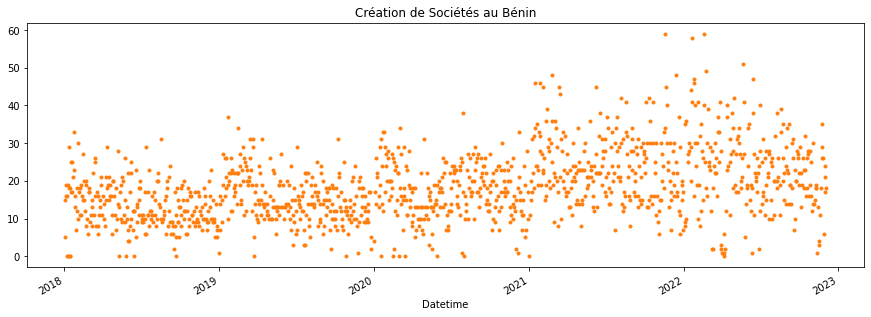

In [10]:
df['company'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title="Création de Sociétés au Bénin")
plt.show()

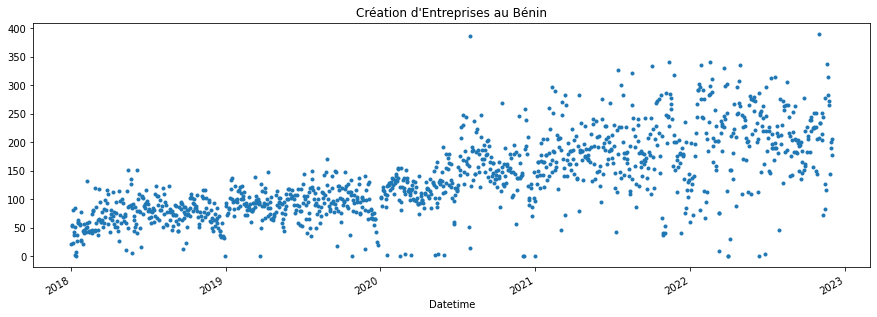

In [11]:
df['establishment'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title="Création d'Entreprises au Bénin")
plt.show()

#### Outlier Analysis 

<AxesSubplot:ylabel='Frequency'>

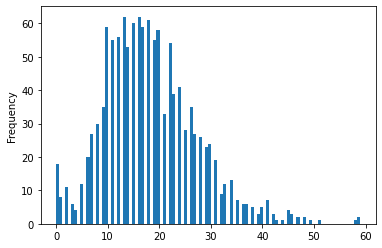

In [12]:
df['company'].plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

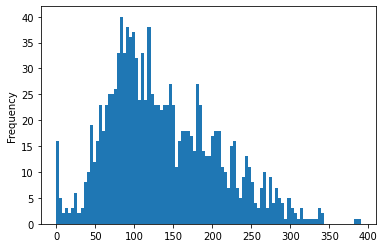

In [13]:
df['establishment'].plot(kind='hist', bins=100)

#### Séparation des données de sociétés et d'établissements  

In [14]:
df_company = pd.DataFrame(df['company'].copy()) 
df_establishment = pd.DataFrame(df['establishment'].copy())

df_company.shape, df_establishment.shape

((1254, 1), (1254, 1))

#### Abscence des données des week-end

Nous pouvons observer dans nos données qu'il n'y a aucune données sur les week-end

In [15]:
df_company.query("index >= '2022-11-12' and index < '2022-11-14' ")

,company
Datetime,


# Utils

### Feature Engineering : Forecasting Horizon Explained

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

**Création de nouvelle caractéristiques à base de celle de DateTime**

In [16]:
def create_features(df0):
    """
    Create time series features based on time series index.
    """
    df0 = df0.copy()
    
    df0['dayofweek']  = df0.index.dayofweek
    df0['quarter']    = df0.index.quarter
    df0['month']      = df0.index.month
    df0['year']       = df0.index.year
    df0['dayofyear']  = df0.index.dayofyear
    df0['dayofmonth'] = df0.index.day
    df0['weekofyear'] = np.int32(df0.index.isocalendar().week) 
    
    df0['is_month_start'] = df0.index.is_month_start
    df0['is_month_end'] = df0.index.is_month_end
    df0['season'] = df0.index.month%12 // 3 + 1
    
    df0['is_month_start'] = df0['is_month_start'].replace({False: 0, True: 1})
    df0['is_month_end'] = df0['is_month_end'].replace({False: 0, True: 1})
    return df0

### Fit and Predict with Cross Validation Function

In [17]:
def fit_and_predict(train_=pd.DataFrame(), test_=pd.DataFrame(), TARGET='company', model=XGBRegressor()):
    # Splitting Data
    tss = TimeSeriesSplit(n_splits=3, test_size=60, gap=24)
    train_ = train_.sort_index()

    preds = []
    scores = []

    for fold, (train_idx, val_idx) in enumerate(tss.split(train_)):
        train = train_.iloc[train_idx]
        valid = train_.iloc[val_idx]

        #Add new features
        train = create_features(train)
        valid = create_features(valid)
        test = create_features(test_)

        # Fixing missing values
        train = train.fillna(0)
        valid = valid.fillna(0)
        test = test.fillna(0)
        
        FEATURES = [col for col in train.columns if col != TARGET ]

        X_train = train[FEATURES]
        y_train = train[TARGET]
        X_valid = valid[FEATURES]
        y_valid = valid[TARGET]
        test = test[FEATURES]

        # Training 
        model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                verbose=0
               )

        # Validation
        y_pred = model.predict(X_valid)

        # Test prediction
        prediction = model.predict(test)
        preds.append(prediction)
        
        # Save Model
        if not os.path.isdir(f"./{TARGET}"):
            os.makedirs(f"./{TARGET}")

        model.save_model(f'./{TARGET}/model{fold}.json')

        # Evaluation
        score = np.sqrt(mean_squared_error(y_valid, y_pred))
        scores.append(score)
        print(f"Fold {fold} MSE Score : {score}")
        print(f"{TARGET} predicted : {np.round(np.sum(prediction))} \n")

    print('=> Total MSE Cross-Validation Scores : ', np.mean(scores), '\n')
    pred = np.mean(preds, axis=0)
    total_value = np.sum(pred)
    print(f'The real {TARGET} values are {test_[TARGET].sum()}, and the predicted {TARGET} values are {np.round(total_value)}')

# Combien de sociétés seront créées en novembre 2022?

Pour résoudre cette question, nous allons:

- créer un model de machine learning
- utiliser les données antérieures (de 3 ans) à cette date pour l’entrainnement de notre modèle
- et tester notre modèle sur les données du novembre 2022


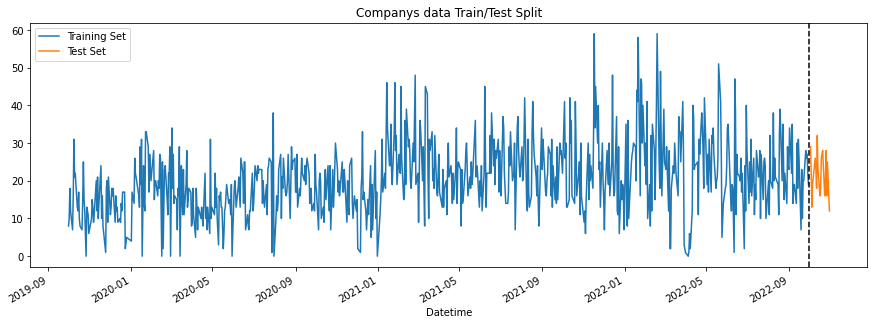

In [18]:
train_ = df_company.query("index >= '2019-10-01' and index < '2022-10-01' ").copy()
test_ = df_company.query("index >= '2022-10-01' and index < '2022-11-01' ").copy()

fig, ax = plt.subplots(figsize=(15, 5))
train_.plot(ax=ax, label='Training Set', title='Companys data Train/Test Split')
test_.plot(ax=ax, label='Test Set')
ax.axvline('2022-10-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

#### Make Predition

In [19]:
# Modeling
model1 = XGBRegressor(base_score=0.5,
                      booster='gbtree',    
                      n_estimators=300,
                      max_depth=5,
                      learning_rate=0.01
                     )
TARGET = 'company'
# Training and Prediction
fit_and_predict(train_, test_, TARGET, model1)

Fold 0 MSE Score : 12.882045892512885
company predicted : 451.0 

Fold 1 MSE Score : 11.464945642040723
company predicted : 445.0 

Fold 2 MSE Score : 7.868012309553738
company predicted : 406.0 

=> Total MSE Cross-Validation Scores :  10.73833461470245 

The real company values are 436.0, and the predicted company values are 434.0


## Conclusion

Notre modèle prédit que `434` Sociétés seront créées en Novembre 2022 contre `436` Sociétés réellements créées.

# Combien de Sociétés seront créées en Décembre 2022?

Pour y parvenir, nous allons :

- générer une série de données du mois de Décembre sans compter les week-end
- créer d'autres caratéristiques à base de celle de la DateTime dont nous disposons
- utiliser les modèles précédemment entraîner pour la prédiction

In [20]:
# Create future dataframe (without week-end data)
future = pd.DataFrame(pd.date_range('2022-12-01','2022-12-31', freq='B'), columns=['Datetime'])
future = future.set_index('Datetime')
future = create_features(future)
future = future.fillna(0)       # Fixing missing values
future.head(3)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_month_start,is_month_end,season
Datetime,,,,,,,,,,
2022-12-01,3,4,12,2022,335,1,48,1,0,1
2022-12-02,4,4,12,2022,336,2,48,0,0,1
2022-12-05,0,4,12,2022,339,5,49,0,0,1


#### Prédiction

In [21]:
FEATURES = future.columns.tolist()

predictions = []
for fold in range(3):
    reg_new = XGBRegressor()
    reg_new.load_model(f'./{TARGET}/model{fold}.json') 
    
    pred = reg_new.predict(future[FEATURES])
    predictions.append(pred)
    
    print(f"Fold {fold} predict : {np.round(np.sum(pred))} {TARGET}")
    
pred = np.mean(predictions, axis=0)
total_value = np.sum(pred)

print("Prédiction Total : ", np.round(total_value))

Fold 0 predict : 469.0 company
Fold 1 predict : 413.0 company
Fold 2 predict : 369.0 company
Prédiction Total :  417.0


## Conclusion

Notre modèle prédit que `417` Sociétés seront créées en Décembre 2022

# Combien d'établissements seront créées en novembre 2022?

Pour résoudre cette question, nous allons:

- créer un model de machine learning
- utiliser les données antérieures (de 3 ans) à cette date pour l’entrainnement de notre modèle
- et tester notre modèle sur les données du novembre 2022


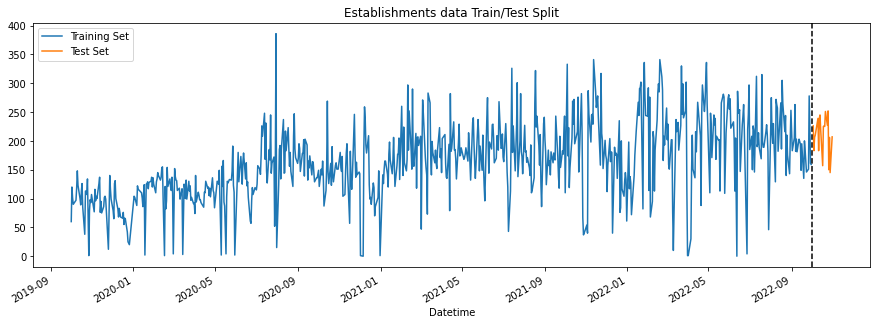

In [22]:
train_est = df_establishment.query("index >= '2019-10-01' and index < '2022-10-01' ").copy()
test_est = df_establishment.query("index >= '2022-10-01' and index < '2022-11-01' ").copy()

fig, ax = plt.subplots(figsize=(15, 5))
train_est.plot(ax=ax, label='Training Set', title='Establishments data Train/Test Split')
test_est.plot(ax=ax, label='Test Set')
ax.axvline('2022-10-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [23]:
# Modeling
model2 = XGBRegressor(base_score=0.5,
                   booster='gbtree',    
                   n_estimators=3500,
                   max_depth=12,
                   learning_rate=0.01
                   )

TARGET = "establishment"

# Training and Prediction
fit_and_predict(train_est, test_est, TARGET, model2)

Fold 0 MSE Score : 93.67554885726028
establishment predicted : 4071.0 

Fold 1 MSE Score : 75.03355465787686
establishment predicted : 4196.0 

Fold 2 MSE Score : 58.908320337612366
establishment predicted : 4075.0 

=> Total MSE Cross-Validation Scores :  75.87247461758317 

The real establishment values are 4222.0, and the predicted establishment values are 4114.0


## Conclusion

Notre modèle prédit que `4114` Établissements seront créées en Novembre 2022 contre `4222` Établissements réellements créées.

# Combien d'établissements seront créées en Décembre 2022?

Même procédé que celui de la prédiction du nombre de Sociétés qui seront créées en Décembre 2022 


In [24]:
# Nous réutilisons les données précédemment générées
future.head(3)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_month_start,is_month_end,season
Datetime,,,,,,,,,,
2022-12-01,3,4,12,2022,335,1,48,1,0,1
2022-12-02,4,4,12,2022,336,2,48,0,0,1
2022-12-05,0,4,12,2022,339,5,49,0,0,1


In [25]:
FEATURES = future.columns.tolist()

predictions = []
for fold in range(3):
    reg_new = XGBRegressor()
    reg_new.load_model(f'./{TARGET}/model{fold}.json') 
    
    pred = reg_new.predict(future[FEATURES])
    predictions.append(pred)
    
    print(f"Fold {fold} predict : {np.round(np.sum(pred))} {TARGET}")
    
pred = np.mean(predictions, axis=0)
total_value = np.sum(pred)

print("Prédiction Total : ", np.round(total_value))

Fold 0 predict : 3869.0 establishment
Fold 1 predict : 3884.0 establishment
Fold 2 predict : 3950.0 establishment
Prédiction Total :  3901.0


## Conclusion

Notre modèle prédit que `3900` Établissements seront créées en Décembre 2022


# Conclusion Générale

- De nombreuses Algorithmes de Machine Learning ont été expérimentés (tels que `LGBMRegressor`, `LinearRegression`, `CatBoostRegressor` et `RandomForestRegressor`) et nous avions remarqué que l'algorithme `XGBRegressor` était le meilleur sur cet ensemble de données.


- On pourrait reprendre l'exercice en s'intéresseant aux nombres d'Entreprises et Sociétés qui pourront être créés dans les mois à venir. 

- En prenant en considération des facteurs comme les domaines d'activités, on pourrait avoir de bonnes prédictions à l'avenir, car d'autres domaines d'activités se crée de jour en jour.

# Ressources

> Original Data source : https://monentreprise.bj/dashboards/public